# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

In [1]:
%matplotlib inline


# Classifying Names with a Character-Level RNN

We will biuld and train a character-level *Recurrent Neural
Network* (*RNN*) to classify words.

A character-level RNN reads words as a series of characters -
it outputs a prediction and hidden state at each step, and feeds the
previous hidden state into each next step. We take the final prediction
to be the output, that represents which class the word belongs to.

We want to predict the Language class to which belongs the Surnames.

## Preparing the Data

We will create a dictionary of lists of names per language,
``{language: [names ...]}``.


In [2]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 39), reused 81 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 1.55 MiB | 17.61 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
# general import

import os
from glob import glob
from io import open
import string
import numpy as np
import random

import torch
import torch.nn as nn


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running application on {device}')

Running application on cuda:0


In [4]:
def getFiles(path):
  return glob(path)

file_list = getFiles('./data/Names/*.txt')
print(file_list[:2])

['./data/Names/Korean.txt', './data/Names/Czech.txt']


In [5]:
!rm -r pytorch-tutorial-nlp-public/

In [6]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

print(readLines(file_list[0]))
print(readLines(file_list[1]))

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha', 'Chang', 'Chi', 'Chin', 'Cho', 'Choe', 'Choi', 'Chong', 'Chou', 'Chu', 'Chun', 'Chung', 'Chweh', 'Gil', 'Gu', 'Gwang ', 'Ha', 'Han', 'Ho', 'Hong', 'Hung', 'Hwang', 'Hyun ', 'Jang', 'Jeon', 'Jeong', 'Jo', 'Jon', 'Jong', 'Jung ', 'Kang', 'Kim', 'Ko', 'Koo', 'Ku', 'Kwak', 'Kwang ', 'Lee', 'Li', 'Lim ', 'Ma', 'Mo', 'Moon', 'Nam', 'Ngai', 'Noh', 'Oh ', 'Pae', 'Pak', 'Park ', 'Ra', 'Rhee', 'Rheem', 'Ri', 'Rim', 'Ron', 'Ryom', 'Ryoo', 'Ryu', 'San', 'Seo', 'Seok', 'Shim', 'Shin', 'Shon', 'Si', 'Sin', 'So', 'Son', 'Song', 'Sook', 'Suh', 'Suk', 'Sun', 'Sung', 'Tsai ', 'Wang', 'Woo', 'Yang', 'Yeo', 'Yeon', 'Yi', 'Yim', 'Yoo', 'Yoon', 'You', 'Youj', 'Youn', 'Yu', 'Yun']
['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch', 'Antonowitz', 'Bacon', 'Ballalatak', 'Ballaltick', 'Bartonova', 'Bastl', 'Baroch', 'Benesch', 'Betlach', 'Biganska', 'Bilek', 'Blahut', 'Blazek', 'Blazek', 'Blazejovsky', 'Blecha', 'Bleskan', 'Blober', 'Bock', 'Bohac', 'Bohunovsky', 'Bolcar', '

In [7]:
# category_words is a dict with the key as the language
# and the value a list with all the possible names in the specific language
category_words = {}
all_categories = []
alphabet = set()

for filename in file_list:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for word in lines:
      alphabet |= set(word)
    category_words[category] = lines

# letter to index
l_to_i = dict(zip(alphabet, range(len(alphabet))))
print(category_words)
n_categories = len(all_categories)
print(f'N. of languages: {n_categories}')
print(l_to_i)
n_letters = len(l_to_i)
print(f'The alphabet has {n_letters} letters')

{'Korean': ['Ahn', 'Baik', 'Bang', 'Byon', 'Cha', 'Chang', 'Chi', 'Chin', 'Cho', 'Choe', 'Choi', 'Chong', 'Chou', 'Chu', 'Chun', 'Chung', 'Chweh', 'Gil', 'Gu', 'Gwang ', 'Ha', 'Han', 'Ho', 'Hong', 'Hung', 'Hwang', 'Hyun ', 'Jang', 'Jeon', 'Jeong', 'Jo', 'Jon', 'Jong', 'Jung ', 'Kang', 'Kim', 'Ko', 'Koo', 'Ku', 'Kwak', 'Kwang ', 'Lee', 'Li', 'Lim ', 'Ma', 'Mo', 'Moon', 'Nam', 'Ngai', 'Noh', 'Oh ', 'Pae', 'Pak', 'Park ', 'Ra', 'Rhee', 'Rheem', 'Ri', 'Rim', 'Ron', 'Ryom', 'Ryoo', 'Ryu', 'San', 'Seo', 'Seok', 'Shim', 'Shin', 'Shon', 'Si', 'Sin', 'So', 'Son', 'Song', 'Sook', 'Suh', 'Suk', 'Sun', 'Sung', 'Tsai ', 'Wang', 'Woo', 'Yang', 'Yeo', 'Yeon', 'Yi', 'Yim', 'Yoo', 'Yoon', 'You', 'Youj', 'Youn', 'Yu', 'Yun'], 'Czech': ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch', 'Antonowitz', 'Bacon', 'Ballalatak', 'Ballaltick', 'Bartonova', 'Bastl', 'Baroch', 'Benesch', 'Betlach', 'Biganska', 'Bilek', 'Blahut', 'Blazek', 'Blazek', 'Blazejovsky', 'Blecha', 'Bleskan', 'Blober', 'Bock', 'Bohac', 'Boh

In [8]:
# this is all the necessary code to set the seed
def set_seed(seed : int = 123):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [9]:
set_seed()

### Turning Names into Tensors

As always, we have to convert textual data into tensors.

To represent a single letter, we use a "one-hot vector" of size
``(1 x n_letters)``, where 1 is the respective index of the letter it is representing.

To make a word we combine a bunch of those representations into a 2D matrix
``(word_length x 1 x n_letters)``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here, for the sake of simplicity.




# Question 1
Create the auxiliary function to process the data to have the input suitable for `nn.Embedding`. This is because one of the following questions will be to try not to use one-hot-encoding representation, but use the embedding layer instead.

In [10]:
def letterToIndex(letter):
  '''
  Returns the index of a letter in the alphabet
  '''
  return l_to_i[letter]

def wordToOneHotTensor(word):
  '''
  Returns the word in zero-hot encoding
  '''
  tensor = torch.zeros(len(word), 1, n_letters).long()
  for idx, let in enumerate(word):
      tensor[idx][0][letterToIndex(let)] = 1
  return tensor

def wordToEmbedding(word):
  indexes = [letterToIndex(letter) for letter in word]
  return torch.tensor(indexes, dtype=torch.long)

tmp = 'Aarle'

print(f'N. of letters {len(alphabet)}')
print(f'Length of the word {len(tmp)}\n')
print(wordToOneHotTensor(tmp).size())
print(wordToOneHotTensor(tmp))
print('\n')
print(wordToEmbedding(tmp).size())
print(wordToEmbedding(tmp))

N. of letters 87
Length of the word 5

torch.Size([5, 1, 87])
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0

# Question 2
Implement the Vanilla RNN considering a batch size of dimension 1 (the simplest case).

## Creating the Network

Here, we are going to create RNNs with one only layer for the sake of simplicity. However, these models can be easily expanded to the more general case of having more layers.  

The Vanilla RNN is just 2 linear layers which operate on an input and hidden state.




In [11]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size).to(device)

In [81]:
class RNNEmb(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNNEmb, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.embedding = nn.Embedding(input_size, hidden_size)

    self.e2h = nn.Linear(hidden_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    embedded = self.embedding(input)
    combined = torch.cat((torch.unsqueeze(embedded, 0), hidden), 1)
    hidden = self.e2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size).to(device)

# Question 3
Implement an LSTM cell considering a batch size of dimension 1 (the simplest case).

In [13]:
class LSTM(torch.nn.Module):

    def __init__(self, input_length, hidden_length, output_length, type_layer):
        super(LSTM, self).__init__()

        self.input_length = input_length
        self.hidden_length = hidden_length
        self.output_length = output_length
        self.type_layer = type_layer

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_input_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.linear_input_w2 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_input = nn.Sigmoid()
        self.tanh_input = nn.Tanh()

        # out gate components
        self.linear_output_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_out = nn.Sigmoid()

        # final compnents
        self.linear_output_final = nn.Linear(self.hidden_length, self.output_length, bias=True)
        self.activation_final = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forget(self, x, h):
        # forget gate
        ret = self.linear_forget_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_forget(ret)


    def input_gate(self, x, h):
        # input gate
        i_t = self.linear_input_w1(torch.cat((x, h), dim=1))
        C_t = self.linear_input_w2(torch.cat((x, h), dim=1))
        return self.sigmoid_input(i_t), self.tanh_input(C_t)


    def out_gate(self, x, h):
        ret = self.linear_output_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_out(ret)


    def forward(self, x, tuple_in):
        x = x.to(torch.float32)
        (h, c_prev) = tuple_in

        # forget gate
        f_t = self.forget(x, h)

        # input gate
        i_t, c_t = self.input_gate(x, h)

        # updating the cell memory
        c_next = (c_prev * f_t) + (i_t * c_t)

        # calculate the main output gate
        o = self.out_gate(x, h)

        # produce next hidden output
        h_next = o * self.activation_final(c_next)

        return self.log_softmax(self.linear_output_final(h_next)), (h_next, c_next)


    def initHidden(self):
        return (torch.zeros(1, self.hidden_length).to(torch.float32).to(device), torch.zeros(1, self.hidden_length).to(torch.float32).to(device))

## Training
Preparing for Training
----------------------

The output of the network is a likelihood of each category. Use ``Tensor.topk`` to get the index
of the greatest value:




In [14]:
def categoryFromOutput(output):
    top_val, top_idx = output.topk(1)
    category_idx = top_idx[0].item()
    return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its
language):




In [15]:
print(all_categories)

['Korean', 'Czech', 'Greek', 'Scottish', 'Arabic', 'Russian', 'Vietnamese', 'Polish', 'French', 'English', 'German', 'Dutch', 'Italian', 'Irish', 'Portuguese', 'Japanese', 'Spanish', 'Chinese']


# Related to Question 1
In order to use the embeddings in place of one-hot-encoded representation, you should modify also the function `randomChoice()` in the following snippet of code to have the correct input data.

In [16]:
import random

def randomChoice(l):
  '''
  Returns a random integer given the list of languages
  '''
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(model):
    category = randomChoice(all_categories)
    word = randomChoice(category_words[category])
    # create a long tensor with the index of the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    if model == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)

    return category, word, category_tensor, word_tensor

for ty in ['embeds', 'linear']:
  for i in range(4):
    category, word, category_tensor, word_tensor = randomTrainingExample(ty)
    print('category =', category, '\n word =', word, '\n category_tensor =', category_tensor, '\n word_tensor =', word_tensor, '\n len word_tensor =', word_tensor.size())
    print('\n')

category = Czech 
 word = Mojjis 
 category_tensor = tensor([1]) 
 word_tensor = tensor([52,  9, 35, 35, 51, 23]) 
 len word_tensor = torch.Size([6])


category = Greek 
 word = Vassilikos 
 category_tensor = tensor([2]) 
 word_tensor = tensor([84, 34, 23, 23, 51, 19, 51,  4,  9, 23]) 
 len word_tensor = torch.Size([10])


category = Irish 
 word = Farrell 
 category_tensor = tensor([13]) 
 word_tensor = tensor([76, 34, 22, 22, 30, 19, 19]) 
 len word_tensor = torch.Size([7])


category = Scottish 
 word = Stewart 
 category_tensor = tensor([3]) 
 word_tensor = tensor([ 8, 81, 30, 61, 34, 22, 81]) 
 len word_tensor = torch.Size([7])


category = Italian 
 word = Rana 
 category_tensor = tensor([12]) 
 word_tensor = tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Training the Network
 In the following change the initialisation with the model you want to use.




In [43]:
n_hidden = 128
criterion = nn.NLLLoss()

In [44]:
rnn = RNN(n_letters, n_hidden, n_categories, 'linear').to(device)
next(rnn.parameters()).device

device(type='cuda', index=0)

In [82]:
rnn_embeds = RNNEmb(n_letters, n_hidden, n_categories, 'embeds').to(device)
next(rnn_embeds.parameters()).device

device(type='cuda', index=0)

In [46]:
lstm = LSTM(n_letters, n_hidden, n_categories, 'linear').to(device)
next(lstm.parameters()).device

device(type='cuda', index=0)

Each loop of training will:

1. Create input and target tensors
2. Read each letter in and keep the hidden state for next letter
3. Compare final output to target
4. Back-propagate
5. Return the output and loss




# Question 3.1
After having tryied the learning rate which is proposed in the script, `0.005`, use the learning rate equal to `1`. What is happening? Can you explaing why?

## Answer
It is happening that the loss goes to NAN values, indeed the problem that we are experiencing in this case is the so called **exploding gradient problem**. Th epoint is that the RNN backbone has the drawback that the closer I move to the end of the sequence of inputs the more I have to add and to multiply the weights of my network. So during the training the graduient might *vanishing* or *exploding* like in this case, so it means that I will not learn lonmg term dependencies.

\begin{equation}
A_t = \Theta_cA_{t-1} + \Theta_xx_t
\end{equation}

Let's consider the recurrence on the hidden space and forget the input
\begin{equation}
 A_t = \Theta_cA_{t-1}
\end{equation}

\begin{equation}
\begin{aligned}
A_1 &= \Theta_cA_0\\
A_2 &= \Theta_cA_1 = \Theta_c(\Theta_cA_0) = \Theta_c^2A_0\\
A_3 &= \Theta_cA_2 = \Theta_c(\Theta_cA_1) = \Theta_c(\Theta_c(\Theta_cA_0)) = \Theta_c^3A_0\\
...\\
A_t &= \Theta_c^tA_0 \quad \text{the parameters are muiltiplied t times}
\end{aligned}
\end{equation}




# Question 3.2
What is the quickest way to get rid of the problem? Modify the code trying to implement a possible solution.
## Answer
The quickest way to get rid of the problem is to modify the code inserting the **gradient clipping**.

Let's $g = \frac{\partial\mathcal{L}}{\partial \Theta_c}$ are the gradeitns of the loss $\mathcal{L}$ with respect to the model's parameters $\Theta_c$

If $||g|| \leq c$ then $g = c \cdot \frac{g}{||g||}$, this ensure that I have no longer strong weights since I make the norm of $g$ maximum of $c$ . Indeed this helps the gradient descent to have a resonabe behaviour even if the loss landscape of the model is irregular.

# Question 3.2
What is the other problem this kind of network has? And what are the possible solutions?
## Answer
The architecture have multiple drowbacks but the main two are the following one:
1. **Limited Contextual Information**: RNNs have a limited ability to capture long-range dependencies in sequences. This is because they suffer from the vanishing gradient problem, which hampers their ability to retain information over many time steps.
2. **Difficulty Learning Long-Term Dependencies**: RNNs find it challenging to learn dependencies that are separated by a large number of time steps. This limits their ability to capture long-term dependencies in sequences. For example given a sequence of words the information of the first word that is kept at the last input is very insignificant respect to the last input word.

One of the possible soluton is to is to switch to an LSTM architecture. The LSTM has the following main advantages respect to a classical RNN:
1. **Gating Structure**: LSTMs incorporate a gating mechanism that consists of input, forget, and output gates. These gates control the information flow, allowing the network to decide what information to keep or forget at each time step.
2. **Long-Term Dependency Handling**: LSTMs are designed to address the vanishing gradient problem, allowing them to capture long-term dependencies. This is achieved through the use of a gating mechanism that regulates the flow of information through the cell state whoch as the main goal to retain the long term memory.
3. **Reduced Vanishing Gradient**: The architecture of LSTMs reduces the vanishing gradient problem, making possible tocapture long term dependencies through the all input sequence.

In [47]:
from torch import optim


def train(category_tensor, word_tensor, model, optimizer):

    h = model.initHidden()

    optimizer.zero_grad()
    # iterate over the word for all the letters in the word
    for i in range(word_tensor.size(0)):

        output, h = model(word_tensor[i], h)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Basic Gradient Clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 1.)

    optimizer.step()
    return output, loss.item()

The ``train`` function returns the output and loss we can print what are its predictions and also to keep track of the loss.
We can choose how many examples print these outputs thanks to ``print_every``.




In [48]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

def run_training(model, optimizer):
  n_iters = 100000
  print_every = 5000
  plot_every = 1000

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []

  model.train()

  start = time.time()

  for iter in range(1, n_iters + 1):
      category, word, category_tensor, word_tensor = randomTrainingExample(model.type_layer)

      category_tensor = category_tensor.to(device)
      word_tensor = word_tensor.to(device)

      output, loss = train(category_tensor, word_tensor, model, optimizer)
      current_loss += loss

      if iter % print_every == 0:
          category_pred, category_idx = categoryFromOutput(output)
          correct = 'OK' if category_pred == category else 'NO (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, word, category_pred, correct))

      # add the current loss to the list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

  return all_losses

In [49]:
optimizer_rnn = optim.SGD(rnn.parameters(), lr = 0.005)

rnn_losses = run_training(rnn, optimizer_rnn)

5000 5% (0m 13s) 2.7118 Sienkiewicz / Russian NO (Polish)
10000 10% (0m 26s) 3.0787 Snelker / German NO (Czech)
15000 15% (0m 39s) 1.9199 Moreau / Spanish NO (French)
20000 20% (0m 52s) 3.5899 Gaspar / Arabic NO (Portuguese)
25000 25% (1m 5s) 1.9662 Humphries / French NO (English)
30000 30% (1m 22s) 0.5968 Sotiris / Greek OK
35000 35% (1m 41s) 0.1350 Guzeev / Russian OK
40000 40% (1m 54s) 0.8015 Padovano / Italian OK
45000 45% (2m 8s) 0.7010 Medeiros / Portuguese OK
50000 50% (2m 21s) 1.3383 Polites / Portuguese NO (Greek)
55000 55% (2m 34s) 0.8847 St pierre / French OK
60000 60% (2m 47s) 3.8145 Hunter / French NO (Scottish)
65000 65% (3m 1s) 1.1178 Ma / Korean NO (Vietnamese)
70000 70% (3m 14s) 1.0559 Chieu / Vietnamese NO (Chinese)
75000 75% (3m 27s) 0.8752 O'Hara / Irish OK
80000 80% (3m 41s) 3.4001 Ki / Korean NO (Japanese)
85000 85% (3m 56s) 0.6653 Said / Arabic OK
90000 90% (4m 9s) 0.6968 Haddad / Arabic OK
95000 95% (4m 24s) 1.8194 Cormack / Irish NO (English)
100000 100% (4m 37

In [83]:
optimizer_rnn_embeds = optim.SGD(rnn_embeds.parameters(), lr = 0.005)

rnn_embeds_losses = run_training(rnn_embeds, optimizer_rnn_embeds)

5000 5% (0m 15s) 1.5026 Nagel / Czech NO (Dutch)
10000 10% (0m 30s) 1.9268 Toma / Japanese NO (Arabic)
15000 15% (0m 47s) 2.0237 Scott / English NO (Scottish)
20000 20% (1m 2s) 1.3441 Nghiem / Vietnamese OK
25000 25% (1m 19s) 0.2423 Fermi / Italian OK
30000 30% (1m 34s) 1.0913 Mathieu / French OK
35000 35% (1m 49s) 2.4625 Black / English NO (Scottish)
40000 40% (2m 4s) 0.7367 Tsumura / Japanese OK
45000 45% (2m 19s) 0.0621 Sniegowski / Polish OK
50000 50% (2m 34s) 0.2210 Duong / Vietnamese OK
55000 55% (2m 49s) 0.1092 Chu / Vietnamese OK
60000 60% (3m 4s) 3.3373 Naylor / Arabic NO (English)
65000 65% (3m 19s) 3.0529 Osman / Irish NO (English)
70000 70% (3m 34s) 1.4906 Canne / Dutch OK
75000 75% (3m 49s) 0.0418 Tieu / Vietnamese OK
80000 80% (4m 4s) 0.2093 Anetakis / Greek OK
85000 85% (4m 19s) 0.0399 Thuy / Vietnamese OK
90000 90% (4m 35s) 2.7783 Clark / Czech NO (Irish)
95000 95% (4m 50s) 0.3541 Matsevich / Russian OK
100000 100% (5m 5s) 1.5553 Victor / Polish NO (French)


In [51]:
optimizer_lstm = optim.Adam(lstm.parameters(), lr = 0.001)

lstm_losses = run_training(lstm, optimizer_lstm)

5000 5% (0m 44s) 0.0159 Czajkowski / Polish OK
10000 10% (1m 40s) 1.4264 Mullins / English NO (French)
15000 15% (2m 22s) 0.6871 Ton / Vietnamese OK
20000 20% (3m 8s) 0.3247 Romijn / Dutch OK
25000 25% (3m 50s) 0.0937 Provenzano / Italian OK
30000 30% (4m 33s) 0.1790 Dunajski / Polish OK
35000 35% (5m 16s) 0.0103 Tsumura / Japanese OK
40000 40% (5m 59s) 0.0554 Thi / Vietnamese OK
45000 45% (6m 42s) 0.0000 Naoimhin / Irish OK
50000 50% (7m 28s) 0.0467 Hakimi / Arabic OK
55000 55% (8m 12s) 0.0155 Tsai  / Korean OK
60000 60% (8m 57s) 0.0382 Jedynak / Polish OK
65000 65% (9m 41s) 0.0024 Reinder / Dutch OK
70000 70% (10m 26s) 0.0582 Ilyunin / Russian OK
75000 75% (11m 10s) 0.0503 Bishara / Arabic OK
80000 80% (11m 53s) 0.6048 Rory / Irish OK
85000 85% (12m 35s) 0.5303 Calogerakis / Greek OK
90000 90% (13m 17s) 0.0915 Hanek / Czech OK
95000 95% (13m 59s) 0.7427 Dobreitser / Russian OK
100000 100% (14m 41s) 0.0217 Baik / Korean OK


# Question 4
Use the LSTM to make the predictions, feel free to modify the optimizer and/or the learning rate to see the training loss decreasing. Pay attention that the LSTM returns a number of components different by the ones that are returned by a Vanilla RNN, thus modify the code accordingly (especially the `train()` function).


# Question 5
Modify the network of the Vanilla RNN to use an embedding layer and not using the one-hot-encoding representation and train again the network. Verify that the network has been trained considering the training loss. It has to be decreasing.

### See that the training loss is decreasing

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def print_losses(all_losses, title):
  plt.figure()
  plt.plot(all_losses)
  plt.xlabel('Iterations')
  plt.ylabel('NLLLoss')
  plt.title(title)
  plt.show()

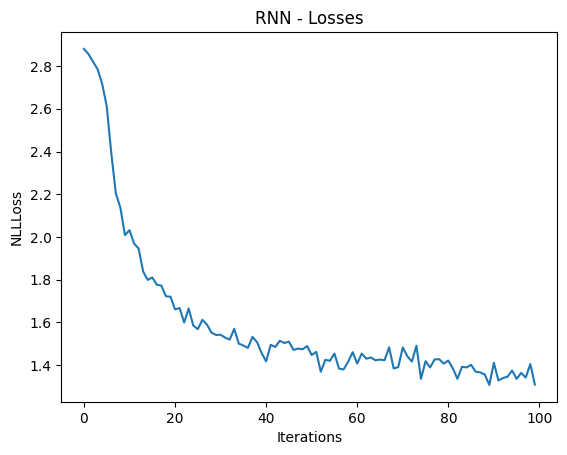

In [53]:
print_losses(rnn_losses, 'RNN - Losses')

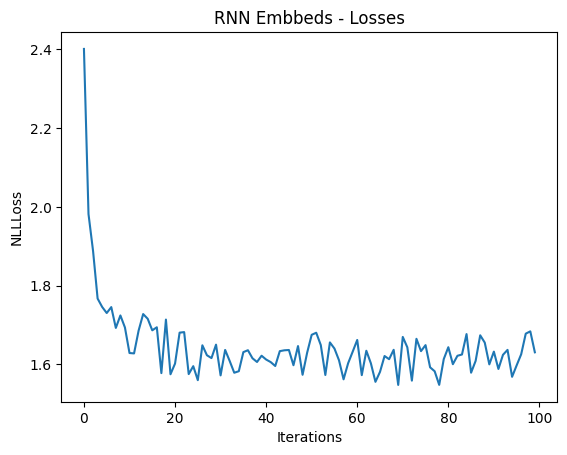

In [98]:
print_losses(rnn_embeds_losses, 'RNN Embbeds - Losses')

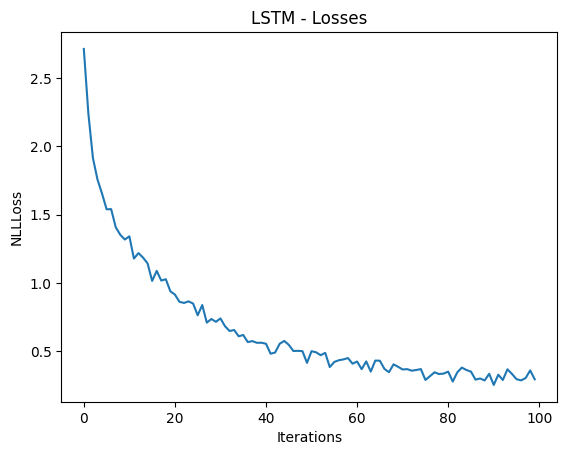

In [55]:
print_losses(lstm_losses, 'LSTM - Losses')

In [56]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()

    line_tensor = line_tensor.to(device)

    hidden = model.initHidden()

    with torch.inference_mode():
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

    return output

def create_confusion_matrix(model):
  # Keep track of correct guesses in a confusion matrix
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, _, _, line_tensor = randomTrainingExample(model.type_layer)
      output = evaluate(line_tensor, model)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig, ax = plt.subplots(figsize=(20, 20))
  cax = ax.matshow(confusion)

  # Display values inside the cells
  for i in range(len(all_categories)):
      for j in range(len(all_categories)):
          ax.text(j, i, str(round(confusion[i, j].item(), 3)), va='center', ha='center', color='white')

  fig.colorbar(cax, shrink=0.8)

  # Set up axes
  ax.set_xticklabels([''] + all_categories, rotation=45)
  ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.xaxis.set_label_coords(0.5, -0.1)
  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.set_ticks_position("none")

  plt.title(f'Confusion Matrix of {model.__class__.__name__}')
  plt.show()

<ipython-input-56-832f2ecd74a7>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-56-832f2ecd74a7>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


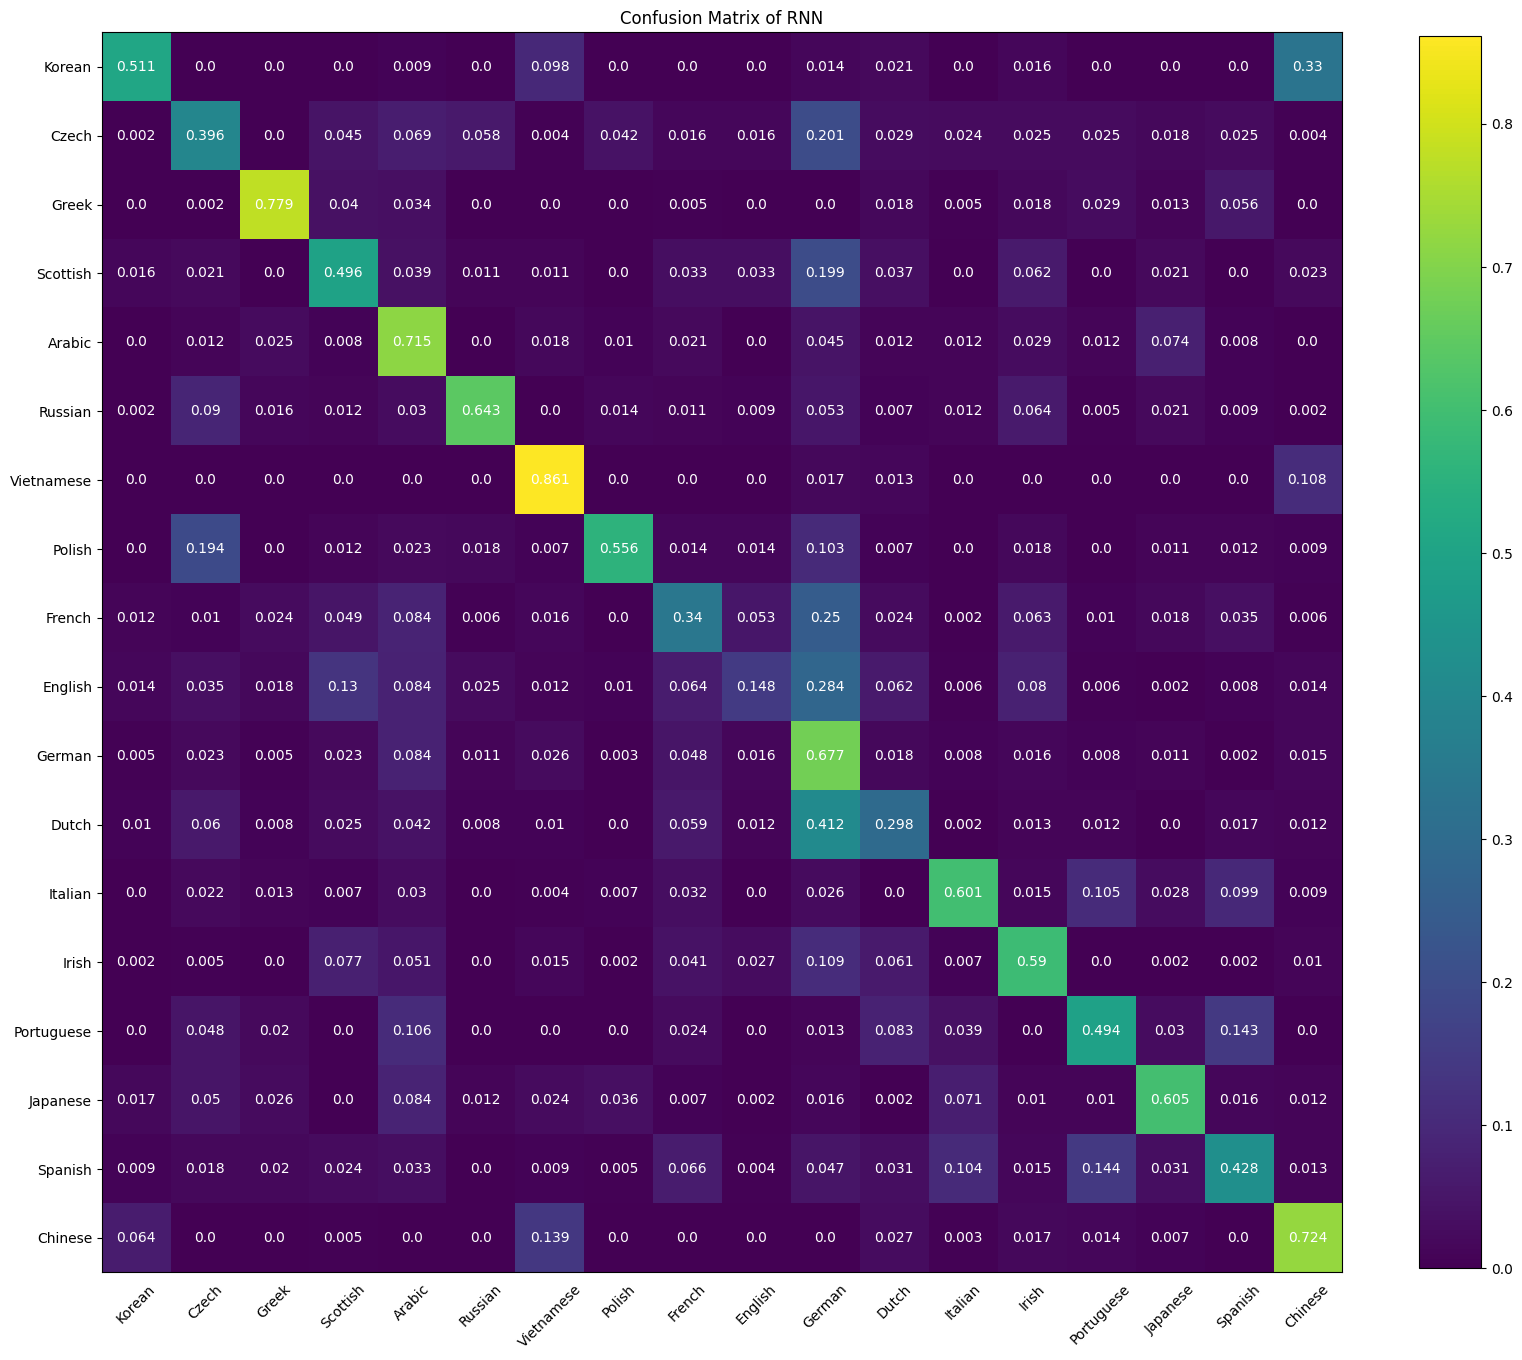

In [57]:
create_confusion_matrix(rnn)

<ipython-input-56-832f2ecd74a7>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-56-832f2ecd74a7>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


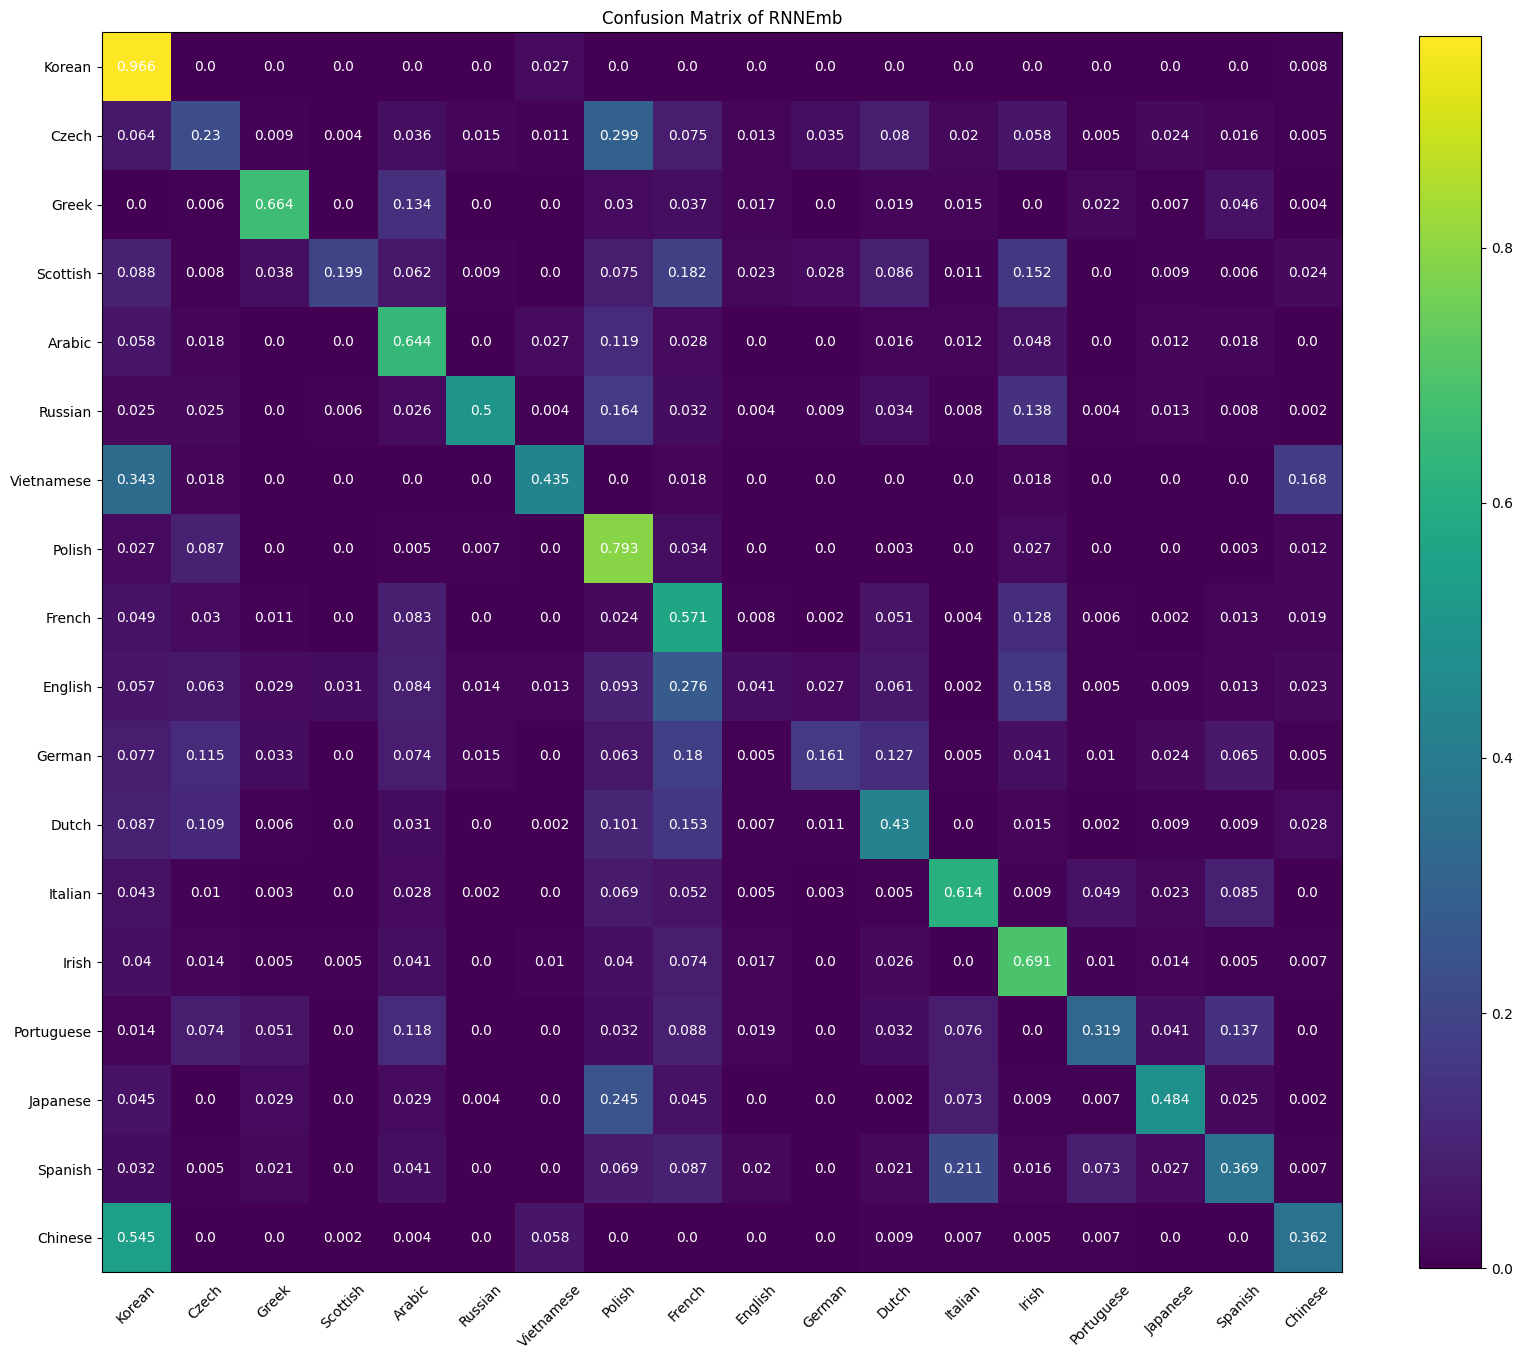

In [99]:
create_confusion_matrix(rnn_embeds)

<ipython-input-56-832f2ecd74a7>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-56-832f2ecd74a7>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


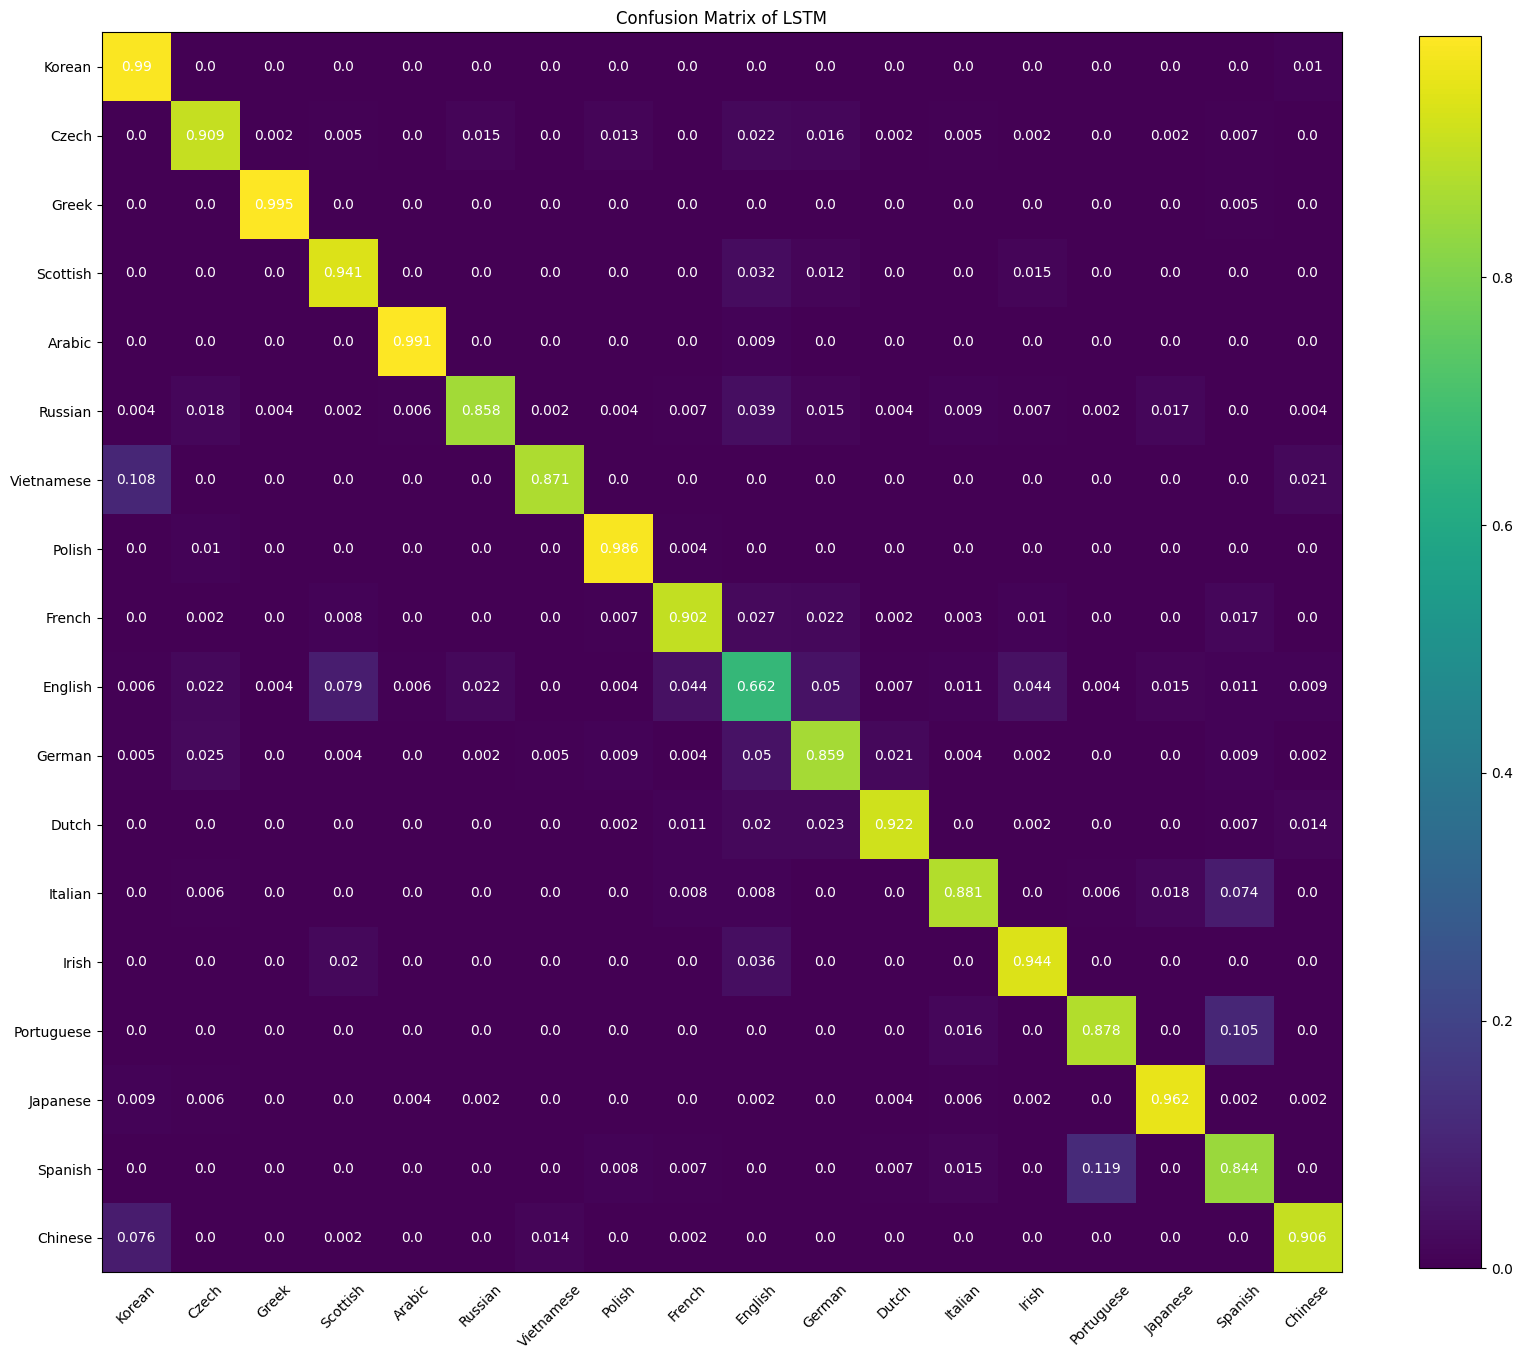

In [59]:
create_confusion_matrix(lstm)

# Question 6
Make a function to extract the embedding and visualise in the 2D space with the color w.r.t. the Language class. Feel free to modify the `get_embeddings()` function to return what you think could be useful for the plotting. Let's use also the cosine similarity between the embeddings to see if the embedding has a sense.

In [77]:
def getTrainingSample(word, type_layer):
    # create a long tensor with the index of the language
    if type_layer == 'linear': return wordToOneHotTensor(word)
    else: return wordToEmbedding(word)

In [61]:
def get_lists_and_dict(category_words):

  sournames, languages_sournames = [], []
  category_words_new = {}

  id = 0
  for lang, list_sournames in category_words.items():
    category_words_new[lang] = []
    for sourname in list_sournames:
      category_words_new[lang].append((id, sourname))
      sournames.append(sourname)
      languages_sournames.append(lang)
      id += 1

  return sournames, languages_sournames, category_words_new

# category_words_new -> dictionary similar to category_words with the additiona id in each sourname
# sournames -> list of sournames derived from the dictionary keys
# languages_sournames -> list of languages derived from the dictionary values

sournames, languages_sournames, category_words_new = get_lists_and_dict(category_words)

In [62]:
def evaluate(line_tensor, model):
    model.eval()
    line_tensor = line_tensor.to(device)

    hidden = model.initHidden()

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

    return output

In [86]:
def get_embeddings(model, category_words_new, lenght):

  embeddings = np.empty((0,128))

  model.eval()  # Set the model in evaluation mode

  # Extract hidden states from your dataset
  # Assuming you have a dataset of sequences, you can iterate over them and collect the hidden states

  correct = 0

  with torch.inference_mode():

      # Iterate over your dataset and extract hidden states
      for lang, list_sourname in category_words_new.items():

          for _, sourname in list_sourname:

              hidden = model.initHidden()

              tensor_sourname = getTrainingSample(sourname, model.type_layer).to(device)

              for i in range(tensor_sourname.size()[0]):
                  output, hidden = model(tensor_sourname[i], hidden)

              category_pred, _ = categoryFromOutput(output)
              if category_pred == lang: correct +=1

              if model.__class__.__name__ == 'LSTM':
                  embeddings = np.vstack((embeddings, hidden[0].cpu().numpy()))
              else:
                  embeddings = np.vstack((embeddings, hidden.cpu().numpy()))

  print(f'Accuracy of {correct / lenght}')
  return embeddings

In [64]:
from sklearn.manifold import TSNE

def get_tsne_embeds(embeds, indices):
  embeds_tsne_indices = TSNE().fit_transform(embeds.squeeze()[indices,:])
  embeds_tsne_all = TSNE().fit_transform(embeds.squeeze()[:,:])
  return embeds_tsne_indices, embeds_tsne_all

In [65]:
import matplotlib.pyplot as plt

def print_embeddings(embeds_tsne_indices, indices, title):
    colors = ['darkblue', 'orange', 'green', 'mediumturquoise', 'darkmagenta', 'khaki', 'dimgray', 'royalblue', 'darkslategray', 'coral', 'mediumorchid', 'saddlebrown', 'lightpink', 'mediumseagreen', 'olivedrab', 'slategray', 'mediumvioletred', 'darkgoldenrod']

    fig, ax = plt.subplots(figsize=(12, 12))

    # Create an empty list to store unique legend entries
    legend_entries = []
    unique_languages = list(category_words.keys())

    for i, val in enumerate(indices):
        color = colors[unique_languages.index(languages_sournames[val])]

        # Check if the language is already in the legend_entries list
        if languages_sournames[val] not in legend_entries:
            # Add the language to legend_entries to avoid duplicates
            legend_entries.append(languages_sournames[val])
            plt.scatter(*embeds_tsne_indices[i, :], color=color, label=languages_sournames[val])
        else:
            # If the language is already in legend_entries, don't add a label
            plt.scatter(*embeds_tsne_indices[i, :], color=color)

    plt.title(title)

    # Display the legend with unique entries
    plt.legend()
    plt.show()

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

def get_embds_sim(embs):
  sim = cosine_similarity(embs)
  np.fill_diagonal(sim, -1.0)
  return sim

In [67]:
viz_words = 2000
indices = np.random.choice(len(sournames), viz_words)

Accuracy of 0.5372123144365847


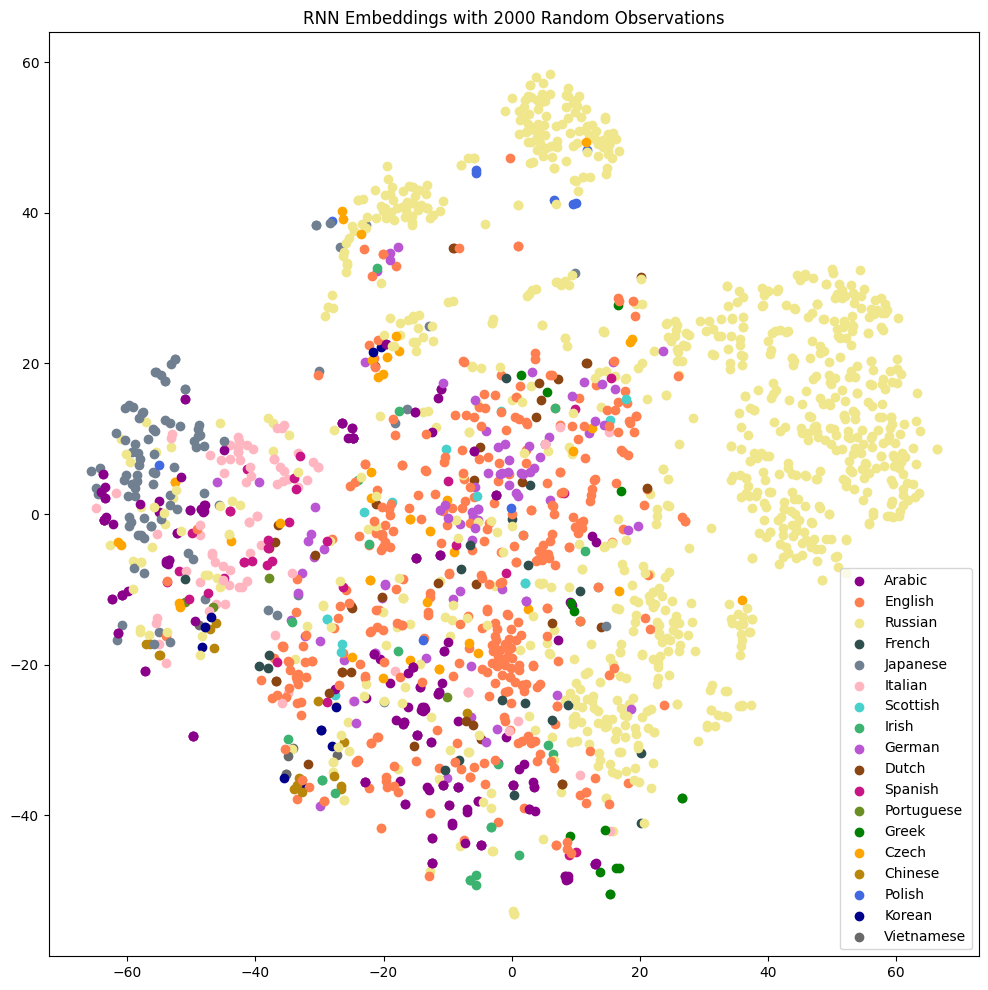

In [78]:
embeds_rnn = get_embeddings(rnn, category_words_new, len(sournames))
embeds_tsne_indices_rnn, embeds_tsne_all_rnn = get_tsne_embeds(embeds_rnn, indices)
print_embeddings(embeds_tsne_indices_rnn, indices, f'RNN Embeddings with {viz_words} Random Observations')
sim_rnn = get_embds_sim(embeds_rnn)

Accuracy of 0.4209425127029989


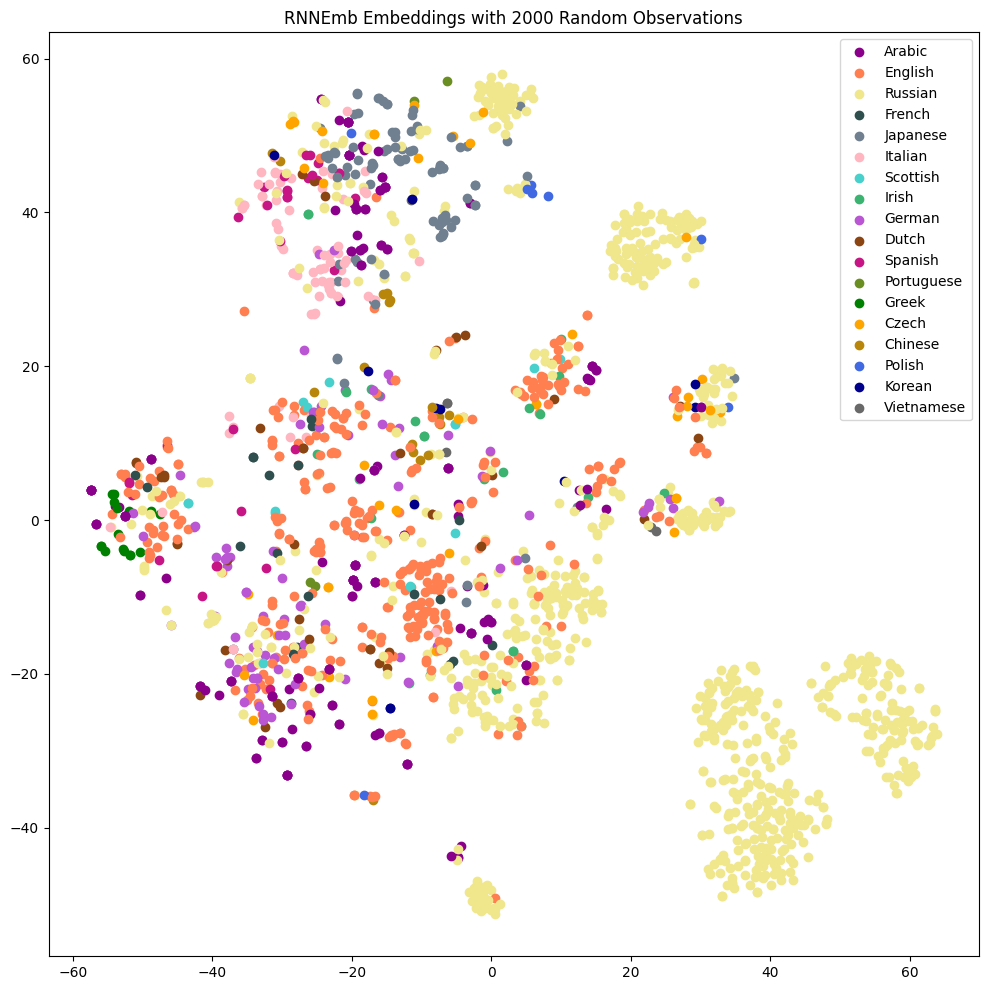

In [85]:
embeds_rnn_emb = get_embeddings(rnn_embeds, category_words_new, len(sournames))
embeds_tsne_indices_rnn_emb, embeds_tsne_all_rnn_emb = get_tsne_embeds(embeds_rnn_emb, indices)
print_embeddings(embeds_tsne_indices_rnn_emb, indices, f'RNNEmb Embeddings with {viz_words} Random Observations')
sim_rnn_emb = get_embds_sim(embeds_rnn_emb)

Accuracy of 0.8424329979077414


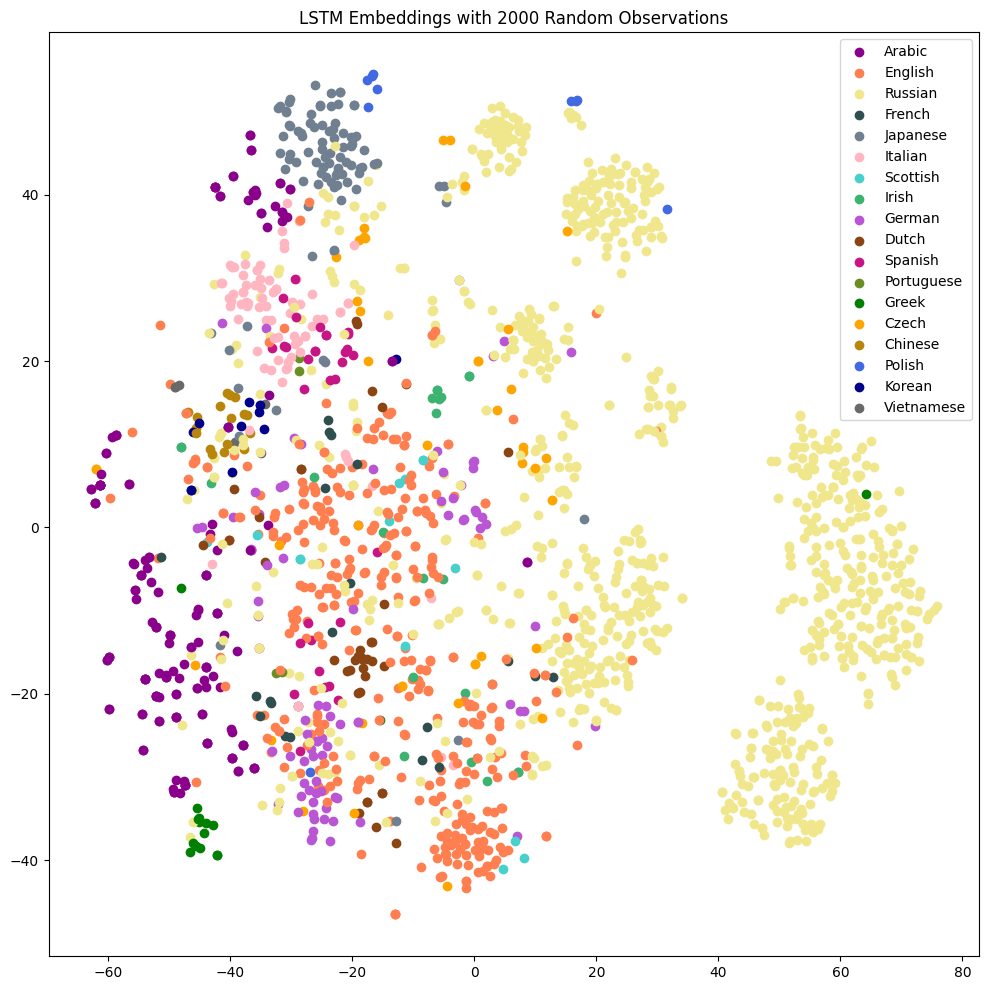

In [87]:
embeds_lstm = get_embeddings(lstm, category_words_new, len(sournames))
embeds_tsne_indices_lstm, embeds_tsne_all_lstm = get_tsne_embeds(embeds_lstm, indices)
print_embeddings(embeds_tsne_indices_lstm, indices, f'LSTM Embeddings with {viz_words} Random Observations')
sim_lstm = get_embds_sim(embeds_lstm)

In [88]:
def get_random_sournames_languages():
  list_idxs_lan_mat_sim = []
  for lang, sournames_list in category_words_new.items():

    id_rand_sourname, str_rand_sourname = random.sample(sournames_list, 1)[0]

    list_idxs_lan_mat_sim.append((id_rand_sourname, languages_sournames[id_rand_sourname]))

  return list_idxs_lan_mat_sim

list_idxs_lan_mat_sim = get_random_sournames_languages()

for id, lan in list_idxs_lan_mat_sim: print(f'{id} - {sournames[id]} - {lan}')

80 - Wang - Korean
309 - Koukal - Czech
736 - Maneates - Greek
886 - Dickson - Scottish
1686 - Totah - Arabic
11048 - Valaev - Russian
12364 - Luc - Vietnamese
12485 - Rutkowski - Polish
12614 - Dubois - French
14656 - Killen - English
16672 - Gerber - German
17473 - Smit - Dutch
17627 - Antonino - Italian
18379 - O'Kelly - Irish
18456 - Coelho - Portuguese
19239 - Shidehara - Japanese
19655 - Loyola - Spanish
19908 - Ming - Chinese


In [89]:
def get_names_similarity(list_idxs_lan_mat_sim, embs_sim, top_k):

  dict_to_return = {}

  for values in list_idxs_lan_mat_sim:

    idx_in_mat_sim, lang = values

    most_sim_sournames_idx = np.flip(np.argsort(embs_sim[idx_in_mat_sim]))[:top_k]
    most_sim_sournames_str = [sournames[idx] for idx in most_sim_sournames_idx]
    most_sim_sournames_lan = [languages_sournames[idx] for idx in most_sim_sournames_idx]
    most_similar_sournames_sim = [embs_sim[idx_in_mat_sim, idx] for idx in most_sim_sournames_idx]

    dict_to_return[idx_in_mat_sim] = (lang, most_sim_sournames_idx)

    print(f'Most similar name for "{sournames[idx_in_mat_sim]} - ({lang})" are:\t{most_sim_sournames_str}')
    print(f'With corresponding languages:\t{most_sim_sournames_lan}')
    print(f'With corresponding indices:\t{most_sim_sournames_idx}')
    print(f'With corresponding Embedding Cosine Similarity of:\t{most_similar_sournames_sim}\n')

  return dict_to_return

In [90]:
# set the top-k names to see for a random name for each language
top_k = 50

In [91]:
dict_sim_rnn = get_names_similarity(list_idxs_lan_mat_sim, sim_rnn, top_k)

Most similar name for "Wang - (Korean)" are:	['Wang', 'Wang', 'Wang', 'Wong', 'Wong', 'Zang', 'Jang', 'Hang', 'Yang', 'Yang', 'Yang', 'Weng', 'Kang', 'Kang', 'Gong', 'Hwang', 'Ang', 'Rang', 'Shang', 'Jong', 'Lang', 'Lang', 'Lang', 'Xing', 'Xing', 'Bang', 'Zhang', 'Zhang', 'Jeong', 'Song', 'Song', 'Zong', 'Geng', 'Yong', 'Hong', 'Hong', 'Hong', 'Jing', 'Kong', 'Eng', 'Sung', 'Sheng', 'Cheng', 'King', 'King', 'Meng', 'Huang', 'Zheng', 'Bing', 'Bing']
With corresponding languages:	['German', 'Chinese', 'English', 'English', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Korean', 'English', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'German', 'Chinese', 'English', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Korean', 'Korean', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'English', 'Scottish', 'Chinese', 'Chinese', 'Chinese',

In [92]:
dict_sim_rnn_emb = get_names_similarity(list_idxs_lan_mat_sim, sim_rnn_emb, top_k)

Most similar name for "Wang - (Korean)" are:	['Wang', 'Wang', 'Wang', 'Wong', 'Wong', 'Weng', 'Gong', 'Jang', 'Xing', 'Xing', 'Xiang', 'Ou-Yang', 'Bang', 'Jong', 'Jiang', 'Au-Yong', 'Bing', 'Bing', 'Song', 'Song', 'Xiong', 'Zang', 'Foong', 'Tang', 'Tang', 'Hong', 'Hong', 'Hong', 'Zong', 'Hang', 'Kang', 'Kang', 'Zhang', 'Zhang', 'Jung', 'Jing', 'Eng', 'Pang', 'Tong', 'Tong', 'Tong', 'Yang', 'Yang', 'Yang', 'Dang', 'Dong', 'Geng', 'Jeong', 'Sung', 'Zhong']
With corresponding languages:	['English', 'German', 'Chinese', 'English', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'Korean', 'Chinese', 'Chinese', 'Chinese', 'English', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'English', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Chinese', 'German', 'Chinese', 'Chinese', 'Chinese', 'Vietnamese', 'Chinese', 'English', 'English', 'Korean', 'Chinese', 'Vietnamese', 'Chinese', 'Chines

In [93]:
dict_sim_lstm = get_names_similarity(list_idxs_lan_mat_sim, sim_lstm, top_k)

Most similar name for "Wang - (Korean)" are:	['Wang', 'Wang', 'Wang', 'Hwang', 'Jang', 'Hang', 'Bang', 'Eng', 'Yang', 'Yang', 'Yang', 'Kang', 'Kang', 'Wong', 'Wong', 'Weng', 'Chang', 'Chang', 'Hong', 'Hong', 'Hong', 'Hung', 'Meng', 'Sung', 'Cheng', 'Tsang', 'Tang', 'Tang', 'Kwong', 'Jung', 'Jong', 'Fung', 'Shang', 'Swann', 'Ming', 'Geng', 'Gong', 'Sheng', 'Wragg', 'Kong', 'Ang', 'Gwang ', 'Kwang ', 'Ling', 'Ling', 'Zong', 'Wane', 'Jing', 'Wan', 'Wan']
With corresponding languages:	['English', 'German', 'Chinese', 'Korean', 'Korean', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Korean', 'English', 'Korean', 'Chinese', 'Chinese', 'English', 'Chinese', 'Chinese', 'Korean', 'Korean', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'English', 'Chinese', 'Chinese', 'German', 'Korean', 'Chinese', 'Chinese', 'English', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'English', 'Chinese', 'Chinese', 'Korean', 'Korean', 'English', 'Chinese', 'Chinese', 'English', 'Chinese',

In [94]:
import seaborn as sns

def plot_point_features(xy_tsne, dictionary, sournames, title):
  x = xy_tsne[:,0]
  y = xy_tsne[:,1]


  plt.figure(figsize=(20, 20))
  plot = sns.scatterplot(x=x, y=y)

  list_colors = ['darkblue', 'orange', 'green', 'mediumturquoise', 'darkmagenta', 'khaki', 'dimgray', 'royalblue', 'darkslategray', 'coral', 'mediumorchid', 'saddlebrown', 'lightpink', 'mediumseagreen', 'olivedrab', 'slategray', 'mediumvioletred', 'darkgoldenrod']
  j = 0

  for target_index, (lang, list_idx_sournames) in dictionary.items():

      plot.text(x[target_index], y[target_index], sournames[target_index], horizontalalignment='center', size='small', color='black', weight='semibold')
      plt.scatter(x[target_index], y[target_index], marker='o', color=list_colors[j])

      top_similar_x = [x[i] for i in list_idx_sournames]
      top_similar_y = [y[i] for i in list_idx_sournames]

      plt.scatter(top_similar_x, top_similar_y, marker='o', color=list_colors[j], label=f'Similar to {sournames[target_index]} ({lang})')

      j += 1

  plt.title(title)
  plt.legend()
  plt.show()

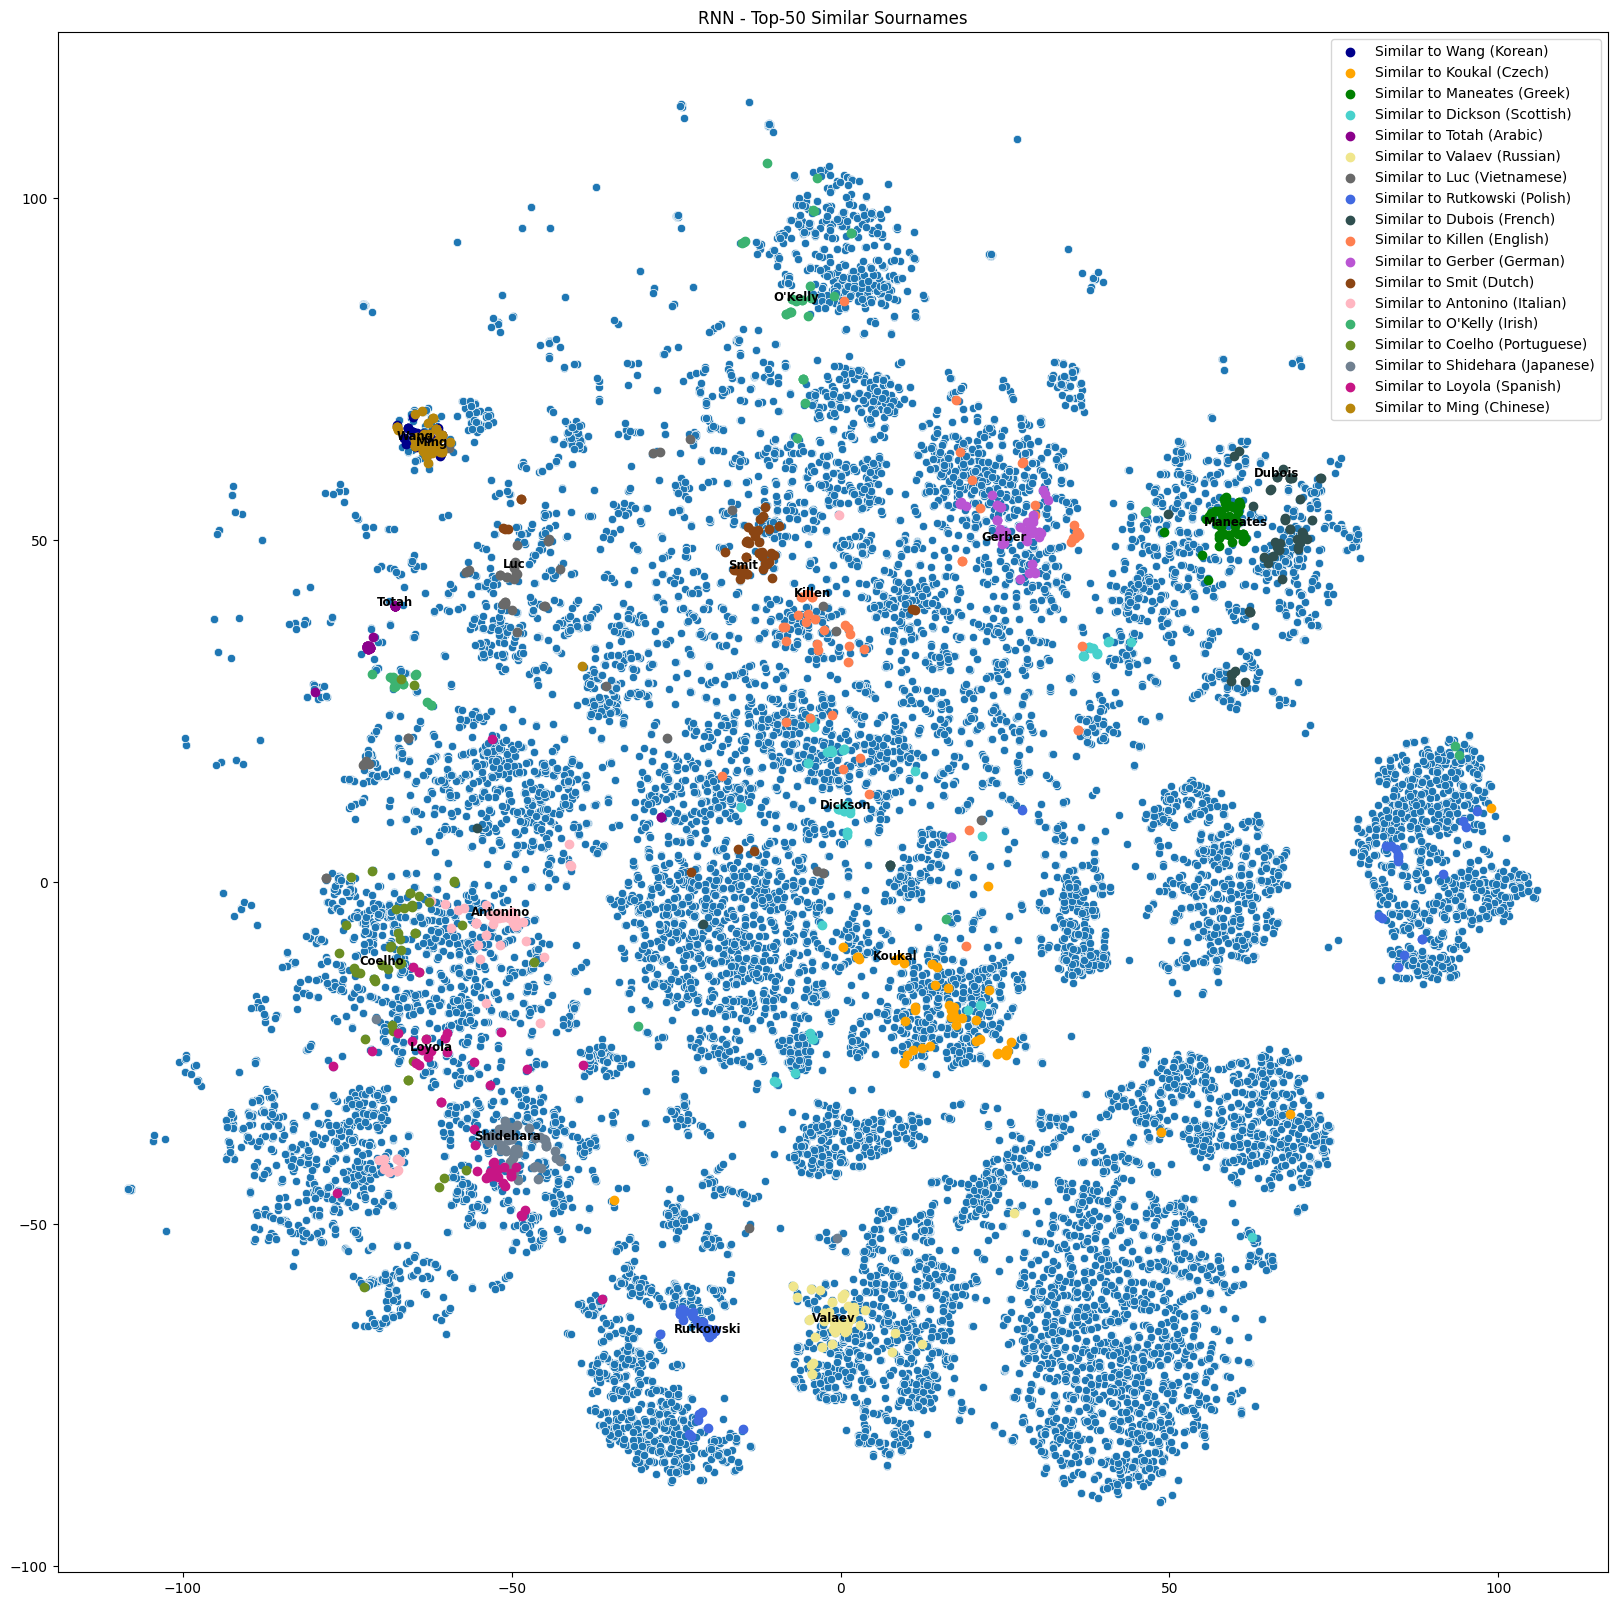

In [95]:
plot_point_features(embeds_tsne_all_rnn, dict_sim_rnn, sournames, f'RNN - Top-{top_k} Similar Sournames')

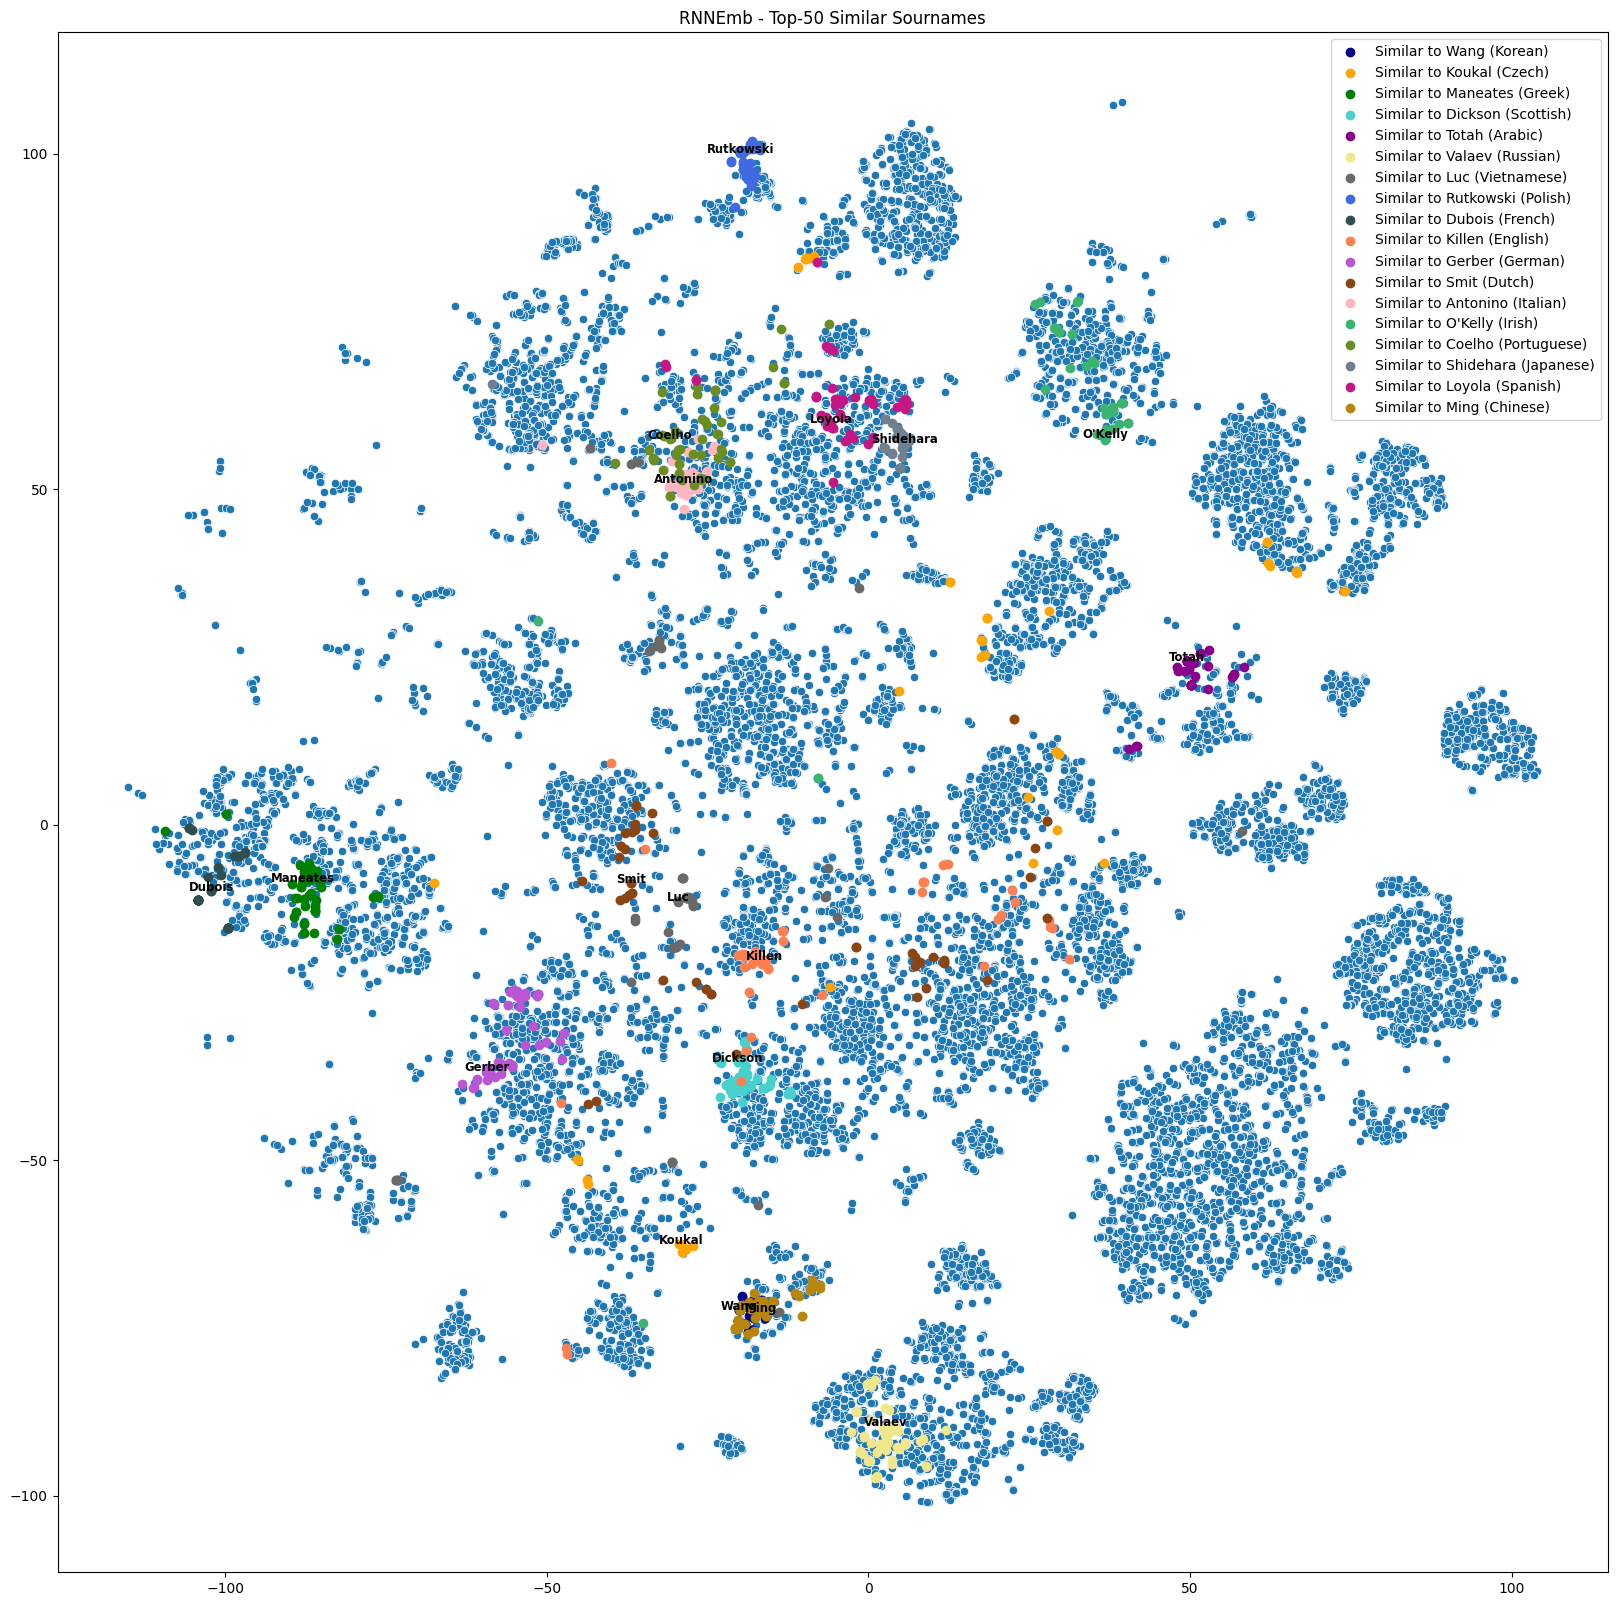

In [96]:
plot_point_features(embeds_tsne_all_rnn_emb, dict_sim_rnn_emb, sournames, f'RNNEmb - Top-{top_k} Similar Sournames')

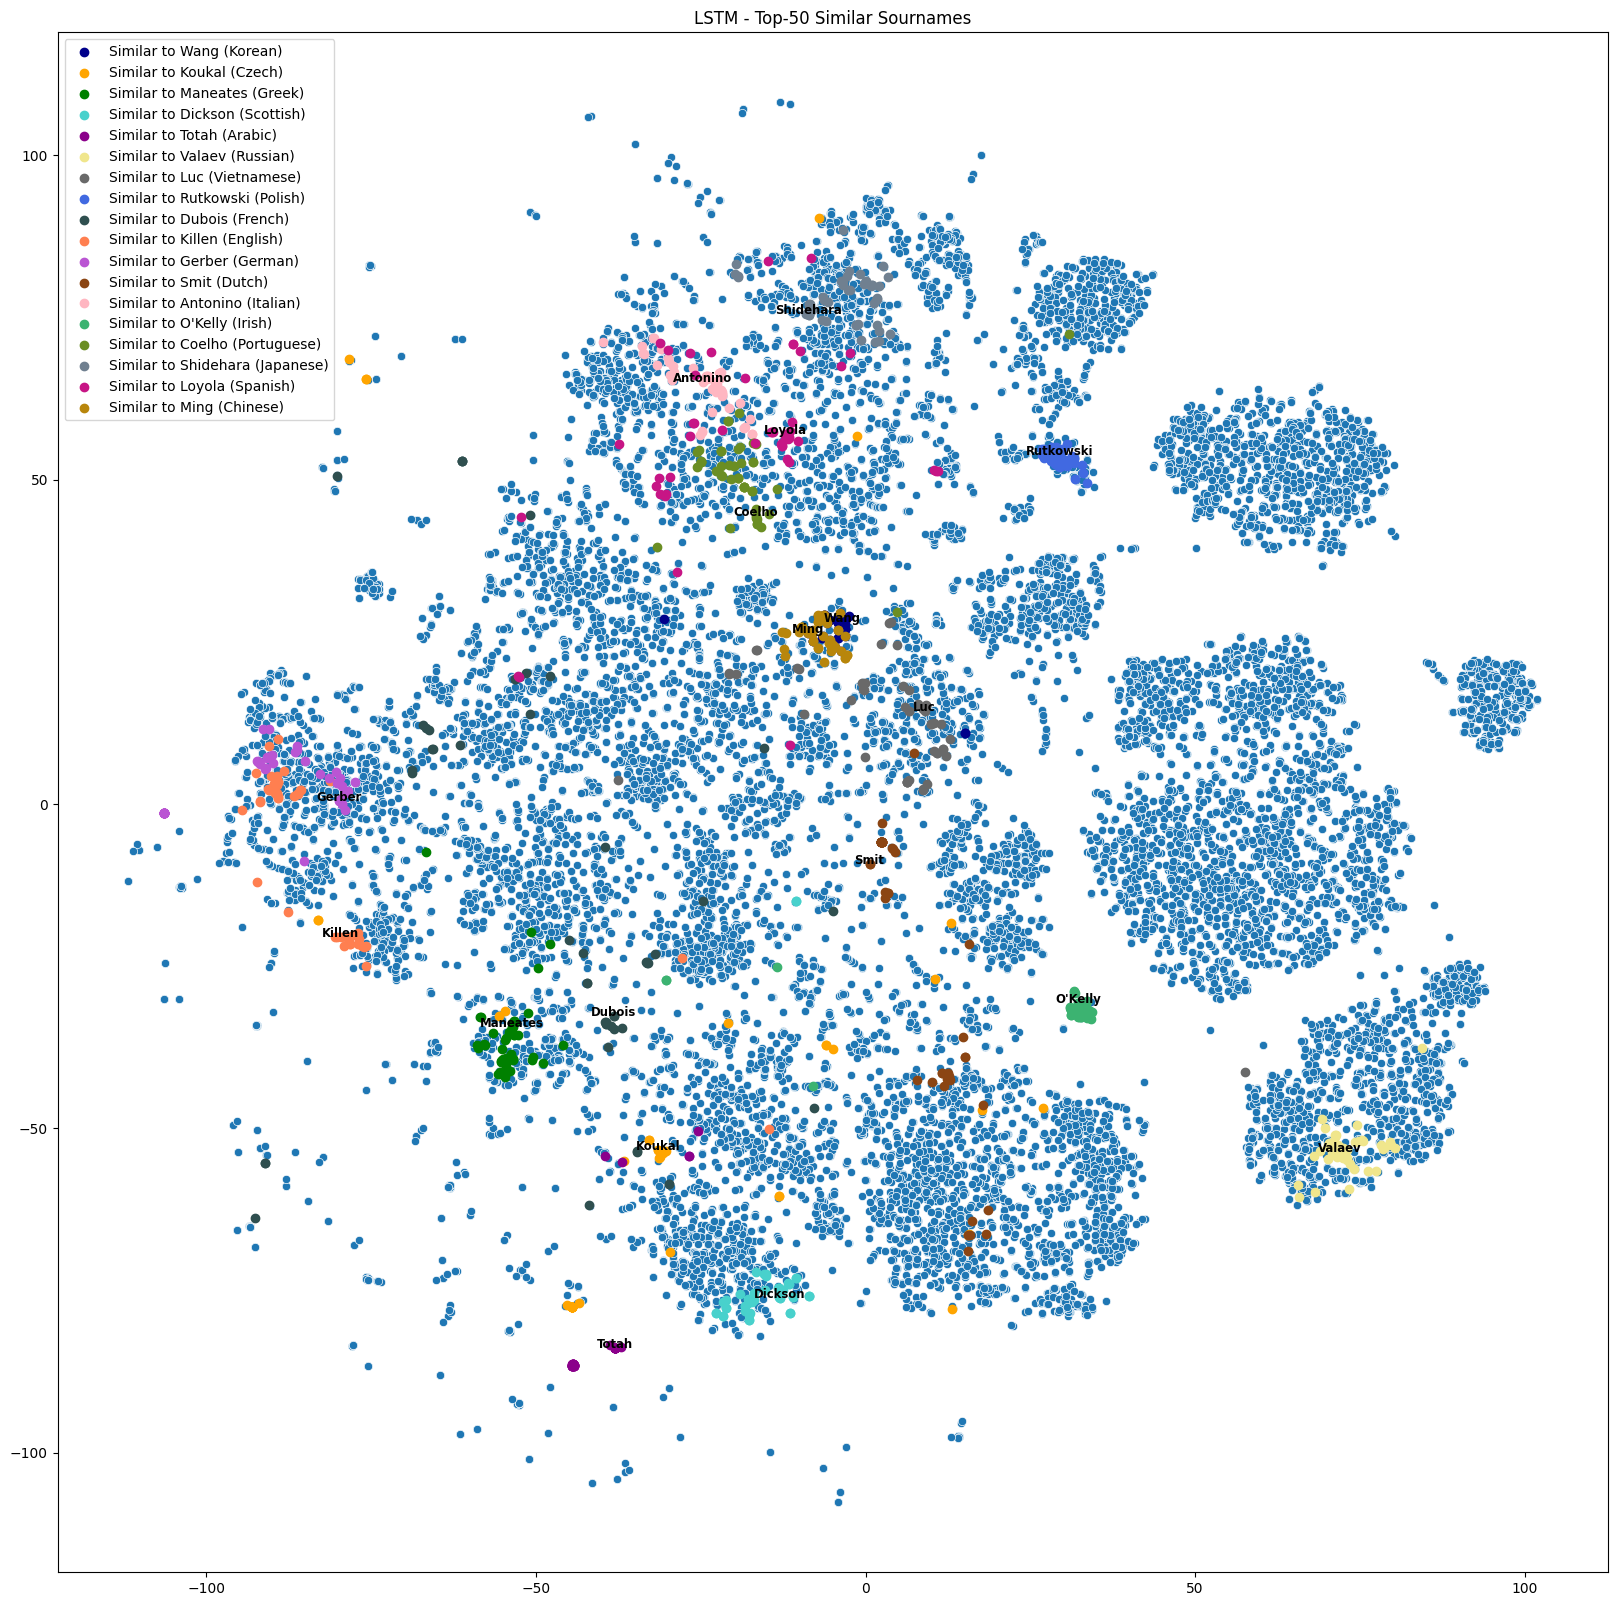

In [97]:
plot_point_features(embeds_tsne_all_lstm, dict_sim_lstm, sournames, f'LSTM - Top-{top_k} Similar Sournames')